<font face="XB Zar" size=5><div dir=rtl align=center>
<font face="IranNastaliq" size=5>
به نام خدا
</font>
<br>
<font size=3>
دانشگاه صنعتی شریف - دانشکده مهندسی کامپیوتر
</font>
<br>
<font color=blue size=5>
مقدمه‌ای بر یادگیری ماشین
</font>
<br>
<hr/>
<font color=red size=6>
فصل هشتم: مدل‌های انتشاری </font>
<br>
نویسنده:‌ علی حاتمی تاجیک
<hr>
</div></font>

<figure id="fig1">
  <img style="display: block;margin-left: auto;margin-right: auto;width: 70%;" src="https://cvpr2022-tutorial-diffusion-models.github.io/img/diffusion.png">
    <figcaption style="text-align: center">شکل ۱: فرآیند کار مدل‌های انتشاری (<a href="https://cvpr2022-tutorial-diffusion-models.github.io">منبع</a>)</figcaption>
</figure>

# ۱. مقدمه

تا کنون در درس درباره مدل‌های مولد VAE و GAN یاد‌گرفته‌اید. هرکدام از این مدل‌ها موفقیت‌های بزرگی بوده‌اند اما هرکدام محدودیت‌هایی دارند. برای مثال مدل‌های GAN به خاطر ذات متخاصمانه خود در فرآیند یادگیری ناپایدار هستند. 

در این نوت‌بوک راجع به **DDPM** ها یا مدل‌های Denoising Diffusion Probabilistic Models (یا به طور خلاصه مدل‌های Diffusion) خواهیم نوشت. این مدل‌ها نوع دیگری از مدل‌های مولد (Generative) هستند که به تازگی (در سال ۲۰۱۵) معرفی شده‌اند. از مدل‌های معروفی که بر این پایه تولید شده‌اند می‌توان به [DALL-E 2](https://openai.com/dall-e-2/) توسط OpenAI و [ImageGen](https://imagen.research.google/) توسط Google Brain اشاره کرد. در ادامه به مقاله اصلی ([Ho et al., 2020](https://arxiv.org/abs/2006.11239))، اصول آن و پیاده‌سازی ساده‌ای از آن در PyTorch خواهیم پرداخت. (*دقت کنید که چندین دیدگاه در مورد مدل‌های دیفیوژن وجود دارد که در اینجا به مدل زمان‌ناپیوسته (discrete-time) می‌پردازیم*).

ایده اصلی که این مدل‌ها برپایه آن بنا شده‌اند این است که در طی چندین مرحله به تصویر نویز اضافه می‌کنند (مانند انتشار دادن مواد شیمیایی به یک سطح) و اگر میزان این نویز مقدار کمی باشد، می‌توان به صورت تقریبی مدل را یک مدل مارکوف در نظر گرفت که وضعیت فعلی آن تنها به وضعیت قبلی آن مرتبط است. ما به دنبال این هستیم تا مدلی عمیق بسازیم تا یاد بگیرد فرایند عکس کردن نویز را یاد بگیرد و با استفاده از وضعیت فعلی، وضعیت قبلی را بسازد (<a href="#fig1">شکل ۱</a>). برخلاف مدل VAE، مدل انتشاری متغیر‌های پنهانی با سایز ورودی اصلی را می‌سازد و یاد می‌گیرد (<a href="#fig2">شکل ۲</a>).

<figure id="fig2">
  <img style="display: block;margin-left: auto;margin-right: auto;width: 70%;" src="./graphics/generative-overview.png" >
    <figcaption style="text-align: center">شکل ۲: تفاوت مدل‌های انتشاری با مدل‌های VAE و GAN (<a href="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/">منبع</a>)</figcaption>
</figure>

پس از اینکه این پروسه نویز‌زدایی (رسیدن از نویز به دیتای ورودی) را یاد گرفتیم، با ورودی دادن یک نمونه تصادفی از نویز به مدل نویز‌زدا می‌توانیم دیتای جدید تولید کنیم.

به طور دقیق‌تر، مدل‌های انتشاری مدل‌هایی با لایه میانی (Latent Variable) هستند که به وسیله یک زنجیره مارکوف **ثابت** فضای ورودی را به فضای میانی (Latent Space) متصل می‌کند (<a href="#fig3">شکل ۳</a>) 

<figure id="fig3">
  <img src="./graphics/x-to-noise.png" style="display: block;margin-left: auto;margin-right: auto;width: 70%;">
    <figcaption style="text-align: center">شکل ۳: فرآیند Forward (<a href="https://arxiv.org/pdf/2006.11239.pdf">منبع</a>)</figcaption>
</figure>

در نهایت مدل با استفاده از در‌ نظر گرفتن این نکته که هر لایه میانی به صورت مجانبی لایه قبلی است ([تحلیل مجانبی](https://fa.wikipedia.org/wiki/%D8%AA%D8%AD%D9%84%DB%8C%D9%84_%D9%85%D8%AC%D8%A7%D9%86%D8%A8%DB%8C) یا Asymptotic analysis) به صورت تدریجی می‌توان ورودی را از روی خروجی ساخت (<a href="#fig4">شکل ۴</a>). هدف از فرآیند یادگیری، یادگرفتن نحوه بازگشت به صورت مجانبی است یا به عبارتی یادگرفتن تابع $p_{\theta}(x_{t-1}\mid x_t)$ است.


<figure id="fig4">
  <img src="./graphics/noise-to-x.png" style="display: block;margin-left: auto;margin-right: auto;width: 70%;">
    <figcaption style="text-align: center">شکل ۴: فرآیند Revers (<a href="https://arxiv.org/pdf/2006.11239.pdf">منبع</a>)</figcaption>
</figure>

## ۱.۱. زنجیره مارکوف (Markov Chain)

«زنجیره مارکوف» (Markov Chain) یا «فرآیند مارکوف» (Markov Process)، مدلی برای نمایش دنباله‌ای از متغیرهای تصادفی است که در آن احتمال رویداد هر پیشامد فقط به پیشامد قبلی وابسته است. به این ترتیب احتمال رخداد پیشامدها در چنین مدلی فقط به زمان قبل وابسته بوده و بقیه پیشامدها در میزان احتمال دخالت نمی‌کنند. چنین وضعیتی را برای فرایند تصادفی گاهی خاصیت «عدم حافظه» (Memoryless) نیز می‌نامند. با فرض مارکوف بودن مدل احتمالاتی می‌توان از پیچیدگی‌های آن کاست. در رابطه زیر $X_i$ را متغیر تصادفی در لحظه $i$ فرض کنید:

$$\large \Pr(X_{t+1}=x\mid X_{1}=x_{1},X_{2}=x_{2},\ldots ,X_{n}=x_{t})=\Pr(X_{t+1}=x\mid X_{t}=x_{t})$$

در عبارت بالا ما این فرض را داریم که مقدار متغیر تصادفی $X_{t+1}$ تنها به وضعیت قبلی سیستم ($X_{t}$) است.

# ۲. چگونگی کار مدل

## ۱.۲. پروسه Forward 


همانطور که پیش‌تر گفت شد، در فرایند Forward ما به صورت تدریجی نویزی به ورودی (که معمولا تصویر است) وارد می‌کنیم. در ابتدای کار ما یک نقطه (یک تصویر) از توزیع داده اصلی (تصاویر اصلی) نمونه‌گیری می‌کنیم: $x_0\sim q(x)$. سپس با استفاده از زنجیره‌ای که تعریف می‌کنیم و اضافه کردن مقدار کمی نویز
<a href="https://en.wikipedia.org/wiki/Multivariate_normal_distribution">گاوسی</a> در $T$ قدم زمانی یک دنباله از نمونه‌های نویزی شده تولید می‌کنیم. اندازه این قدم‌های زمانی توسط برنامه واریانس $\{\beta_t \in (0, 1)\}_{t=1}^T$ کنترل می‌شود:

$$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$$

<details><summary><u>جزئیات ریاضی «اضافه شدن» نویز</u></summary>

   در فرآیند Forward از اضافه شدن نویز به نمونه‌ها صحبت می‌کنیم اما چنین چیزی در رابطه‌ای که نوشته شده است عملیات جمعی نمی‌بینیم! در ادامه جزئیات ریاضی که منجر به نتیجه مطلوب می‌شود شرح داده‌شده است. در ابتدا توجه داشته باشید که:
   
   $$\mathcal{N}(x;\mu, \sigma)=\frac{1}{\sigma \sqrt{2 \pi}}\exp(-\frac{1}{2}(\frac{x-\mu}{\sigma})^2)$$
    
   حال با استفاده از قانون احتمال کل خواهیم داشت:
   
$$p_{X_t}=\int p(x_t \mid x_{t-1})p(x_{t-1})dx_{t-1}$$
    
   با جایگزین کردن توزیع گاوسی داریم:
    
   $$p_{X_t}=\int \mathcal{N}(x_t;x_{t-1}, 1) p(x_{t-1})dx_{t-1} = \int \mathcal{N}(x_t - x_{t-1};0, 1) p(x_{t-1})dx_{t-1}$$ 
   
   که با قدری دقت متوجه خواهید شد که این همان <a href="https://en.wikipedia.org/wiki/Convolution">کانوولوشن</a> است:
   
   $$p_{X_t}=(N(0,1)*p(x_{t-1}))(x_t)$$
    
   که طبق <a href="https://en.wikipedia.org/wiki/Convolution_of_probability_distributions">کانوولوشن توزیع‌های احتمالاتی</a> برابر خواهد بود با:
    
   $$X_t = \mathcal{N}(0,1) + X_{t-1}$$  
</details>

زمانی که $T$ به اندازه کافی بزرگ باشد (در عمل معمولا ۱۰۰) $x_T$ به صورت یکنواخت نویز گاوسی است. معمولا برنامه واریانس، بر خلاف این نکته که می‌توانند یاگرفته‌شوند، مقادیر ثابت و مستقل از زمانی گرفته می‌شوند. یک راه برای انتخاب مقدار آنها، انتخاب خطی آنها بین $\beta_0 = 10^{-4}, \beta_T = 0.2$ است.

## ۲.۲. پروسه Revese

برای بدست آوردن توزیع $q(x_{t-1}\mid x_t)$ و تخمین زدن آن باید روی کل دیتاست عملیات انجام بدهیم که کار ساده‌ای نخواهد بود به همین دلیل ما مدل $p_\theta$ را یاد می‌گیریم تا این تابع احتمال را تقریب بزنیم.

$$p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod^T_{t=1} p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) \quad
p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))$$

که در آن مدل یاد می‌گیرد تا پارامترهای مستقل از زمان آن یادگرفته خواهند شد.


<figure id="fig5">
  <img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/diffusion-example.png" style="display: block;margin-left: auto;margin-right: auto;width: 70%;">
    <figcaption style="text-align: center">شکل ۵: فرآیند Forward و Revers روی دیتای ساده عددی (رول سوئیسی) (<a href="https://lilianweng.github.io/posts/2021-07-11-diffusion-models">منبع</a>)</figcaption>
</figure>

## ۳.۲. Objective و تابع Loss

مدل ما سعی می‌کند تا انتقال معکوس زنجیره مارکوف را به گونه‌ای یاد بگیرد تا امید‌ریاضی دیتای ورودی بیشینه شود. در عمل، یادگیری برای کمینه کردن <a href="https://arxiv.org/pdf/1611.00328.pdf">حد پایین واریانس</a> منفی امید‌ریاضی خواهد بود:

$$\begin{aligned}
L_\text{VLB} 
&:= \mathbb{E}_{q(\mathbf{x}_{0:T})} \Big[ \log \frac{q(\mathbf{x}_{1:T}\vert\mathbf{x}_0)}{p_\theta(\mathbf{x}_{0:T})} \Big] \geq - \mathbb{E}_{q(\mathbf{x}_0)} \log p_\theta(\mathbf{x}_0)
\end{aligned}$$

به دلیل اینکه توزیع گاوسی در KL Divergence دارای فرم بسته است، می‌خواهیم تا $L_{VLB}$ را به این صورت بنویسیم. تبدیل شده آن به صورت زیر خواهد بود (جزئیات ریاضی را می‌توانید <a href="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#reverse-diffusion-process">اینجا</a> ببینید):

$$\begin{aligned}
L_\text{VLB} &= L_T + L_{T-1} + \dots + L_0 \\
\text{where } L_T &= D_\text{KL}(q(\mathbf{x}_T \vert \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T)) \\
L_t &= D_\text{KL}(q(\mathbf{x}_t \vert \mathbf{x}_{t+1}, \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_t \vert\mathbf{x}_{t+1})) \text{ for }1 \leq t \leq T-1 \\
L_0 &= - \log p_\theta(\mathbf{x}_0 \vert \mathbf{x}_1)
\end{aligned}$$

همانطور که قبل‌تر اشاره شد برنامه واریانس به صورت ثابت انتخاب می‌شود، به همین دلیل مدل ما تنها میانگین را از هر مرحله به مرحله بعد یاد‌خواهد گرفت. در نظر بگیرید که $\alpha_t = 1 - \beta_t$ و $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$. در [Ho et al., 2020](https://arxiv.org/abs/2006.11239) به عبارت Loss پارامتری شده و ساده‌شده‌ای رسیده‌اند که 

$$\begin{aligned}
L_t^\text{simple}
&= \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)\|^2 \Big] \\
&= \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)\|^2 \Big]
\end{aligned}$$

در نهایت الگوریتم یادگیری و نمونه‌گیری خواهند بود:

<figure id="fig6">
  <img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png" style="display: block;margin-left: auto;margin-right: auto;width: 70%;">
    <figcaption style="text-align: center">شکل ۶: الگوریتم‌ها (<a href="https://arxiv.org/abs/2006.11239">منبع</a>)</figcaption>
</figure>


# ۳. پیاده‌سازی

در این بخش دو پیاده‌سازی برای مدل‌های دیفیوژن را ارائه خواهیم کرد. اولی روی دیتاست Swiss Roll است که برای آشنایی بیشتر شما با مفاهیم دیفیوژن است و دیگری یک پیاده‌سازی به وسیله دیتاست با داده واقعی‌تر (Fashion MNIST) و به وسیله معماری‌های پیچیده‌تر انجام می‌گیرد تا نمونه‌ای از این مدل را در عمل ببینید. قبل از شروع این پیاده‌سازی‌ها ابتدا توابعی پایه که برای پیاده‌سازی مدل‌های انتشاری استفاده می‌شوند را پیاده‌سازی می‌کنیم و سپس به آموزش مدل روی دیتاست‌های نام‌برده خواهیم پرداخت. 

In [1]:
!pip install -q -U einops tqdm

In [2]:
import math
import numpy as np
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image

from sklearn.datasets import make_swiss_roll

from PIL import Image

from unet import Unet

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## ۱.۳. توابع پایه

اولین قدم، تخصیص مقادیر بتا و متغیر‌های وابسته به آن مانند آلفاست:

In [4]:
def linear_beta_schedule(T):
    """Get Linear beta schedule for T time steps
    
    Args:
        T: positive integer time steps
        
    Returns torch.tensor of T elements
    """
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, T)

In [5]:
T = 200

# get the schedule
betas = linear_beta_schedule(T)

# alpha and alpha comprods
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [6]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

همچنین فرآیند‌های نمونه‌برداری را می‌توان به صورت زیر انجام داد: 

In [7]:
def q_sample(x_0, t, noise=None):
    """Sample X0 for forward deffusion (Algorithm 1, line 2)"""
    if noise is None:
        noise = torch.randn_like(x_0)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

In [8]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    """Sampling (1 iteration in the Algorithm 2 lines 3 and 4)
    
    Note: This function is vectorized and do one itteration for
          sample batch-size (i.e. shape[0] in `p_sample_loop`)
    """
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

In [9]:
@torch.no_grad()
def p_sample_loop(model, shape):
    """Algorithm 2: Sampling (Vectorized for #shape[0] outputs)
    """
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size=28, batch_size=16, channels=1):
    """Wrapper for p_sample_loop"""
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

و در نهایت می‌توانیم تابع هزینه (MSE) را پیاده‌سازی کنیم:

In [10]:
def f_loss(model, x_0, t, noise=None):
    """
    MSE Loss of the noisy image at step t and the noise
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    
    x_noisy = q_sample(x_0, t, noise)
    predicted_noise = model(x_noisy, t)
    
    return  F.mse_loss(noise, predicted_noise)

## ۲.۳. پیاده‌سازی PyTorch (داده Swiss Roll)

 

پیش از شروع کار داده‌های رولت سوییسی (Swiss Roll) که یک دیتاست کلاسیک است را به تصویر می‌کشیم تا آشنایی بهتری با آن پیدا کنیم. 

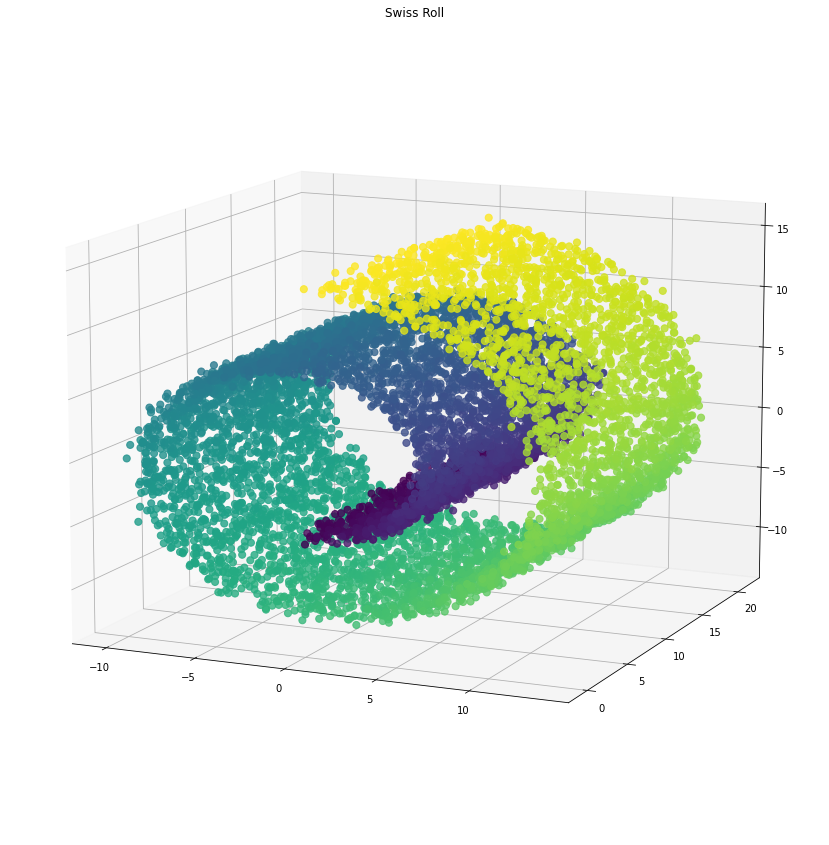

In [11]:
roll_size = 10_000
roll_data, sr_color = make_swiss_roll(roll_size, noise=0.3)

# Plot
def plot_3d(data, color, title):
    """Plots 3d scatter of data
    
    Args:
        data: 3 x N array-like
        color: N x 1 array correspoding to each row of data
        title: title of the chart
    """
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection="3d")
    fig.add_axes(ax)
    ax.scatter(
        data[:, 0], data[:, 1], data[:, 2], c=color, s=50, alpha=0.8
    )
    ax.set_title(title)
    ax.view_init(azim=-66, elev=12)
    
plot_3d(roll_data, sr_color, "Swiss Roll")
plt.show()

حال نویزدار شده این داده را در قدم‌های مختلف زمانی را به نمایش درمی‌آوریم (در دو بعد):

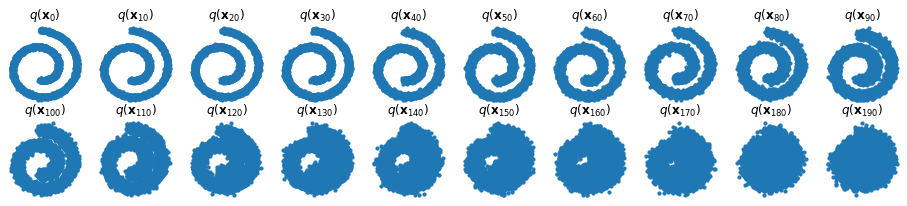

In [12]:
roll_t = torch.tensor(roll_data).float()

def plot_diffusion():
    """
    This function plots diffusion proccess for the input data
    """
    fig = plt.figure(figsize=plt.figaspect(0.2))
    for i in range(20):
        ax = fig.add_subplot(2, 10, i+1)
        q_i = q_sample(roll_t, torch.tensor([i * 10]))
        ax.scatter(q_i[:, 0], q_i[:,2], s=10);
        ax.set_axis_off(); ax.set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

plot_diffusion()

حال یک شبکه عصبی برای یادگرفتن فرآیند بازگشت از نویز به دیتای اصلی می‌سازیم: 

In [13]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, T):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(T, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
    
class ConditionalModel(nn.Module):
    def __init__(self, T):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(3, 128, T)
        self.lin2 = ConditionalLinear(128, 128, T)
        self.lin3 = nn.Linear(128, 3)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

In [14]:
class EMA():
    """Exponential Moving Average
    
    This idea is found in most of the implementations, which allows to implement a form 
    of model momentum. Instead of directly updating the weights of the model, we keep a
    copy of the previous values of the weights, and then update a weighted mean between
    the previous and new version of the weights.
    """
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

tensor(0.8870, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.6781, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.7701, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.6371, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.8892, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.7428, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.7662, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.7818, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9560, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.7951, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.7595, device='cuda:0', grad_fn=<MseLossBackward>)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

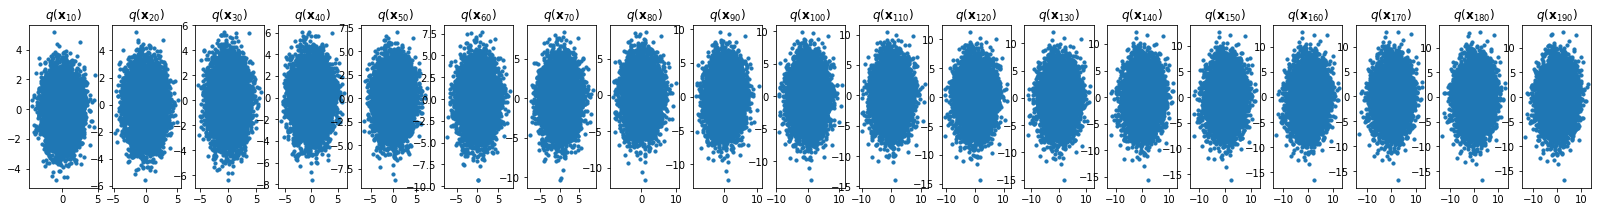

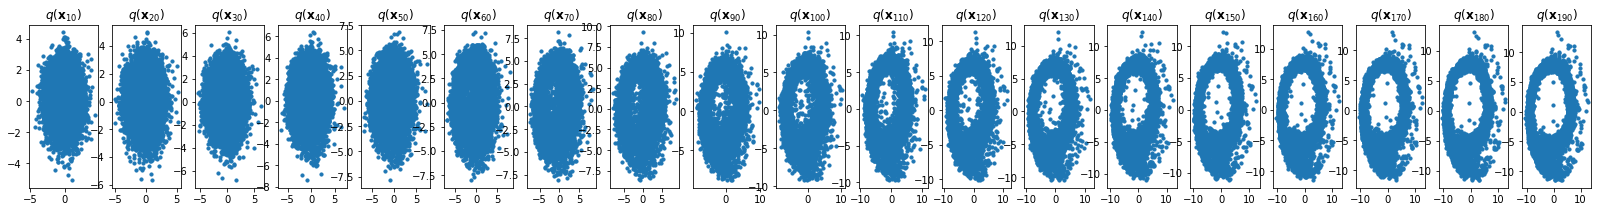

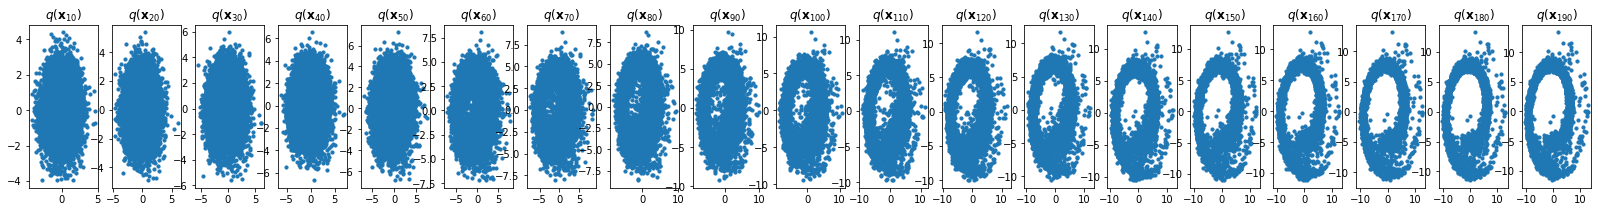

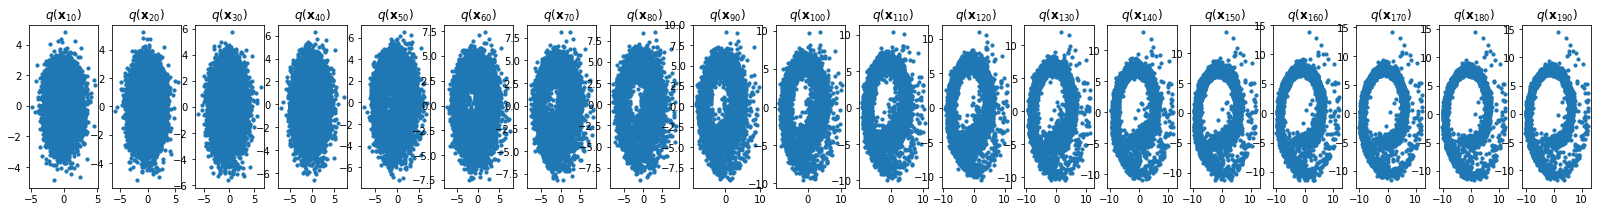

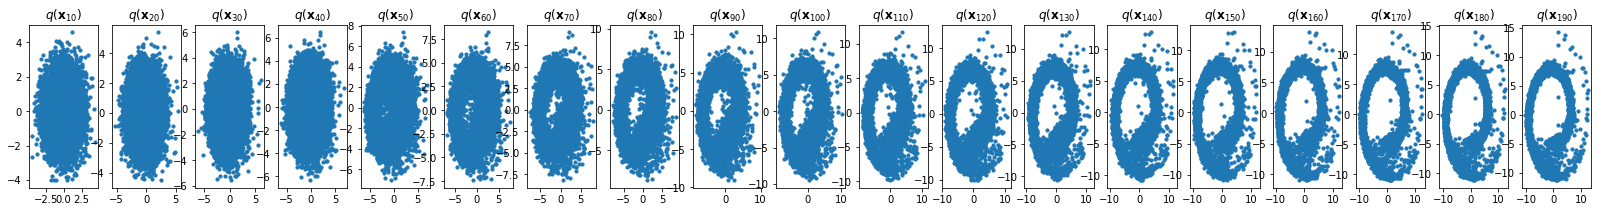

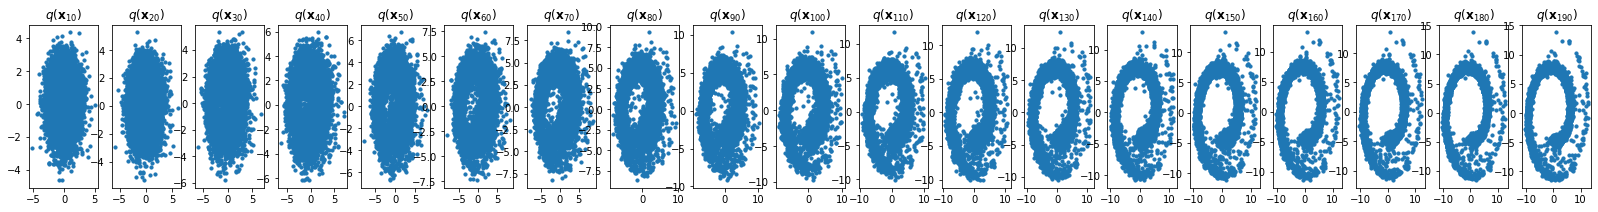

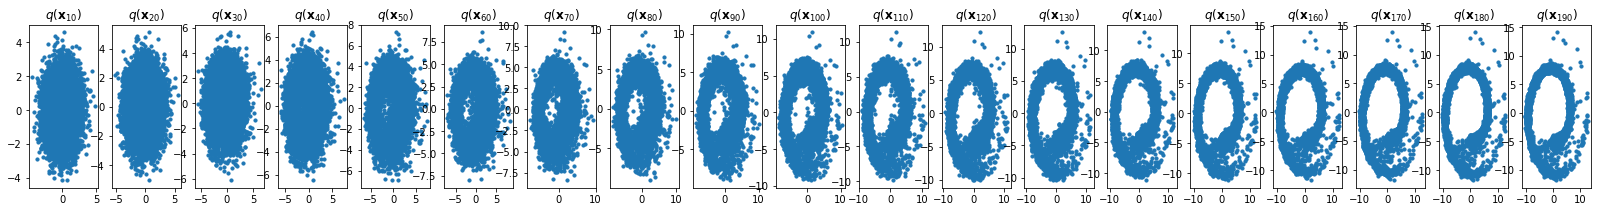

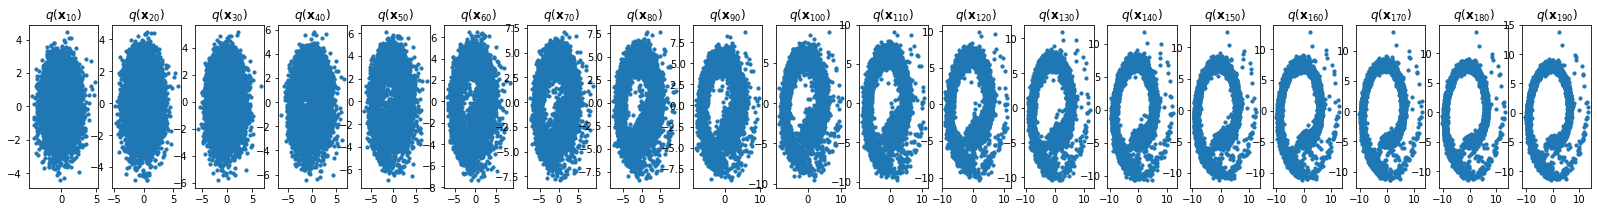

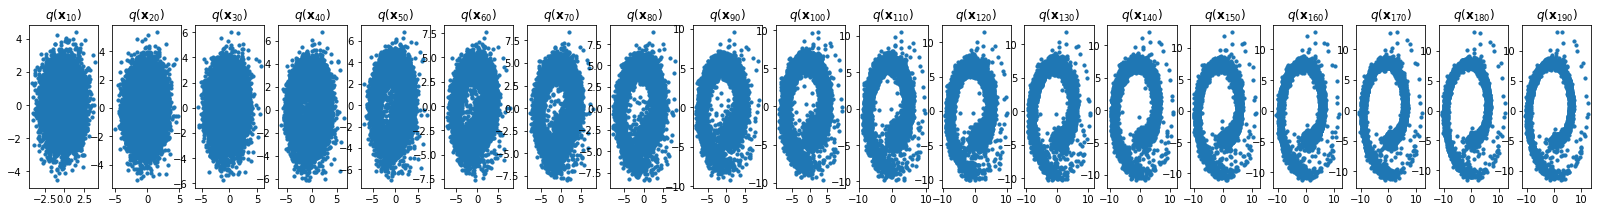

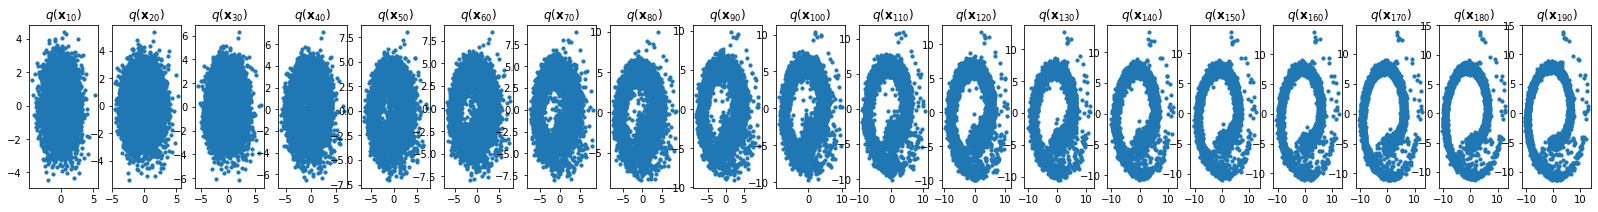

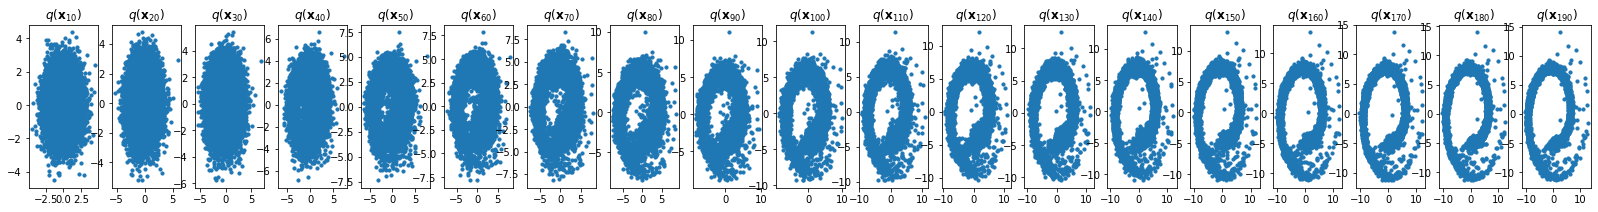

In [15]:
model = ConditionalModel(T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 100
for step in range(2001):
    # X is a torch Variable
    permutation = torch.randperm(roll_t.size()[0])
    for i in range(0, roll_t.size()[0], batch_size):
        optimizer.zero_grad()
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = roll_t[indices].to(device)
        
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, T, (batch_size,), device=device).long()
            
        # Compute the loss.
        loss = f_loss(model, batch_x, t)
        loss.backward()
        
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        
        # Calling the step function to update the parameters
        optimizer.step()
        
        # Update the exponential moving average
        ema.update(model)
    
    # Print loss
    if (step % 200 == 0):
        print(loss)
        x_seq = p_sample_loop(model, roll_t.shape)
        fig, axs = plt.subplots(1, 19, figsize=(28, 3))
        for i in range(1, 20):
            cur_x = x_seq[i * 10]
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 2], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

## ۳.۳. پیاده‌سازی PyTorch (داده واقعی)

در این بخش یک مدل دیفیوژن با استفاده از شبکه‌های عمیق کانولوشنال خواهیم ساخت.

برای یادگرفتن فرآیند بازگشت، به خاطر پیچید بودن این فرآیند، از شبکه‌های عصبی استفاده می‌کنیم. می‌خواهیم از تصویر نویز‌دار ورودی نویز آن را پیش‌بینی کنیم (که ابعاد هر دو یکسان است). معماری که در ابتدا به ذهن می‌رسد معماری Autoencoderهاست. در [[Ho et al., 2020](https://arxiv.org/abs/2006.11239)] نویسندگان از معماری مشابه UNet ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)) بر پایه CNNها استفاده کرده‌اند (<a href="#fig7">شکل ۴</a>)

<figure id="fig7">
  <img src="https://amaarora.github.io/images/unet.png" style="display: block;margin-left: auto;margin-right: auto;width: 70%;">
    <figcaption style="text-align: center">شکل ۷: UNet (<a href="https://amaarora.github.io/2020/09/13/unet.html">منبع</a>)</figcaption>
</figure>

به خاطر برخی پیچیدگی‌های خارج از مبحث این مدل، مانند لایه‌های Residual و Attention، این مدل شبکه عصبی در فایل `unet.py` آماده شده است، اما شما می‌توانید مراحل پیاده‌سازی آن را در <a href="https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=5153024b">این نوت‌بوک فوق‌العاده</a> ببینید (کدهای این نوت‌بوک ساده‌سازی‌شده کد‌های مرجع ذکرشده است). 

## ۱.۳. فرآیند Forward

فرآیند اضافه شدن نویز به تصاویر را دنبال می‌کنیم:

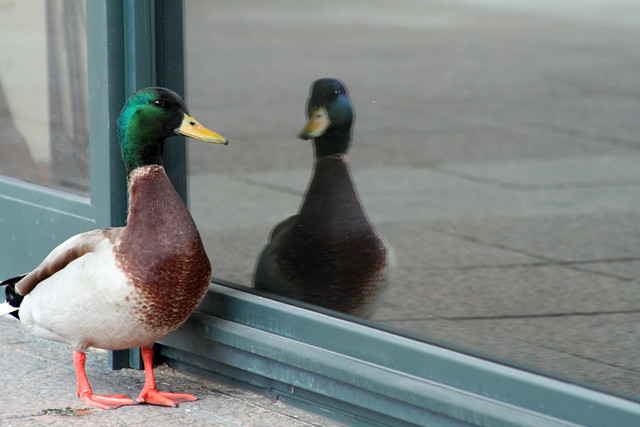

In [16]:
ducky = Image.open("./graphics/duck.jpg")
ducky

دقت کنید که نویز به وسیله PyTorch اضافه می‌شود به همین خاطر قبل از آن باید عکس‌های PIL را به تنسور تبدیل کنیم. در مقاله DDPM پیکسل‌های تصویر به مقادیر بین -۱ تا ۱ اسکیل شده‌اند:

> We assume that image data consists of integers in $\{0, 1, ... , 255\}$ scaled linearly to $[−1, 1]$. This
ensures that the neural network reverse process operates on consistently scaled inputs starting from
the standard normal prior $p(\mathbf{x}_T )$. 

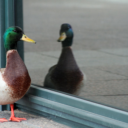

In [17]:
image_size = 128

trans = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: t * 2 - 1)
])

rev_trans = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)),
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

rev_trans(trans(ducky))

In [18]:
def get_noisy_image(x_0, t):
    # add noise
    x_noisy = q_sample(x_0, t=t)

    # turn back into PIL image
    noisy_image = rev_trans(x_noisy.squeeze())

    return noisy_image

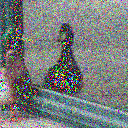

In [19]:
x_0 = trans(ducky).unsqueeze(0)
# take 40 time steps
t = torch.tensor([40])
get_noisy_image(x_0, t)

In [20]:
# use seed for reproducability
torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """Plot sequence images in rows
    
    Source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
    """
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

حال یک دنباله از تصاویر نویزدار شده در چند بخش را نمایش می‌دهیم تا با نویزی شدن تصاویر بیشتر آشنا شوید:

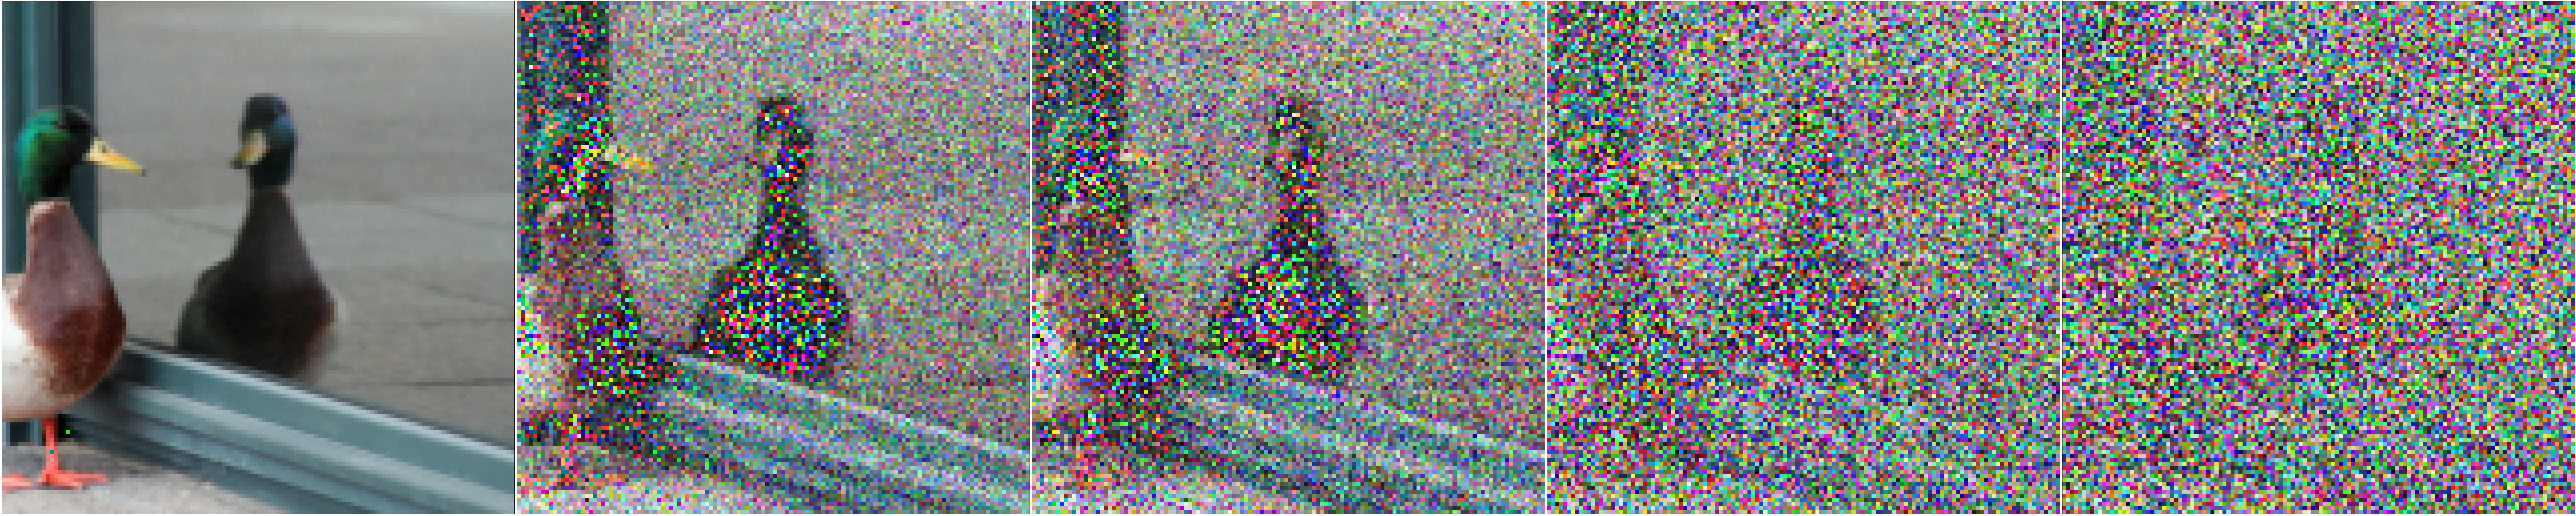

In [21]:
plot([get_noisy_image(x_0, torch.tensor([t])) for t in [0, 40, 50, 80, 99]])

## ۲.۳. دیتاست

دیتاست Fashion MNIST برای یادگیری انتخاب شده است اما می‌توانید از دیتاست‌های دیگری مانند CIFAR10 استفاده کنید.

In [22]:
transform = Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

mnist = datasets.FashionMNIST('./data', download=True, transform=transform)

In [23]:
batch_size = 64
loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

## ۳.۳. نمونه‌گیری

## ۴.۳. یادگیری (Train)

In [24]:
model = Unet(dim=28, channels=1, dim_mults=(1, 2, 4, )).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
T = 100
epochs = 50 # ~ 5 Hours

for epoch in range(epochs):
    with tqdm(enumerate(loader), total=len(loader)) as pbar:
        for step, (images, _) in pbar:
            optimizer.zero_grad()

            batch_size = len(images)
            images = images.to(device)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            t = torch.randint(0, T, (batch_size,), device=device).long()

            loss = f_loss(model, images, t)
            
            if step % 100 == 0:
                pbar.set_description(f'Train {epoch} | Loss:{loss.item():.4f}')

            loss.backward()
            optimizer.step()
    print(loss)

  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2169, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1540, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1360, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1298, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1464, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1446, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1084, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1500, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1707, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1194, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1178, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1005, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1352, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1099, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1200, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.0974, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1356, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1170, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1020, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1213, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1243, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1503, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1077, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1242, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1246, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1006, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1318, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1171, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.0970, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1330, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1612, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1046, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1382, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1222, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1120, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1282, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1134, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1203, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1477, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1196, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1414, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1202, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1280, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1075, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.0924, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1101, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1101, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1184, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1220, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.1333, device='cuda:0', grad_fn=<MseLossBackward>)


## ۵.۳. استنتاج (نمونه گیری)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

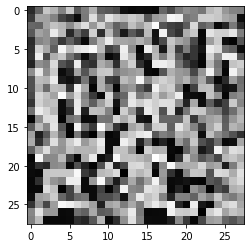

In [28]:
# generating 32 images and plot 7th image
samples = sample(model, image_size=28, batch_size=32, channels=1)
plt.imshow(samples[-1][8].reshape(28, 28, 1), cmap="gray")

نتیجه تولید شده که چیزی شبیه به یک پیراهن است :) همانطور که می‌بینید برای اینکه مدل‌های انتشاری روی داده‌های پیچیده‌تر نتایج مطلوبی داشته باشند تعداد epoch کم جوابگو نخواهد بود و برای مدت طولانی باید پروسه یادگیری را طی کنند ($epoch\sim 1000$)

# ۴. منابع و مراجع

منابعی که برای نوشته‌شدن این نوت‌بوک به کار گرفته شده است: 

* [Ho et al., 2020](https://arxiv.org/abs/2006.11239) 
* [CVPR 2022](https://cvpr2022-tutorial-diffusion-models.github.io/): CVPR 2022 یکی از بهترین منابع برای یادگیری و آشنایی با مدل‌های انتشاری است. [دکتر آرش وحدت](http://latentspace.cc/) (محقق Nvidia) یکی از ارائه دهندگان این آموزش هستند. اسلاید‌های فوق‌العاده این ارائه‌ها را می‌توانید از [این لینک](https://drive.google.com/file/d/1DYHDbt1tSl9oqm3O333biRYzSCOtdtmn/view?usp=sharing) دانلود کنید.
* [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) 
* [Introduction to Diffusion Models for Machine Learning](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/) 
* [An introduction to Diffusion Probabilistic Models](https://ayandas.me/blog-tut/2021/12/04/diffusion-prob-models.html) 
* [U-Net: A PyTorch Implementation in 60 lines of Code](https://amaarora.github.io/2020/09/13/unet.html) 
* [The Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion) 

# ۵. منابع مفید برای مطالعه بیشتر

برای آشنایی عمیق‌تر و با جزئیات بیشتر می‌توانید به مقاله [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) و [An introduction to Diffusion Probabilistic Models](https://ayandas.me/blog-tut/2021/12/04/diffusion-prob-models.html) مراجعه کنید. همچنین اگر می‌خواهید یک مدل متن به تصویر (چیزی شبیه به ImageGen) بسازید می‌تواند یک آموزش قدم-به-قدم را در مقاله [MinImageGen](https://www.assemblyai.com/blog/minimagen-build-your-own-imagen-text-to-image-model/) دنبال کنید. همچنین مخزن گیت‌هاب [Awesome Diffusion Model](https://github.com/heejkoo/Awesome-Diffusion-Models) مقالات، پست‌ها، ویدئو‌ها و ... مرتبط با این موضوع را به صورت دسته‌بندی شده جمع‌آوری می‌کند که می‌توانید از مراجع معرفی شده در آن استفاده کنید.